# Case:

We are answering questions about grades over time at UW-Madison to see if it qualifies for a fictitious donor's annual donation.
Our evaluation metric will be the school's grade-points-per-credit system
<img src="school_weighted_metric.png" alt="grade point per credit chart" height="320" width="480">


## Criteria:
<ol>
    <li>STEM education</li>
	<li>STEM progression</li>
	<li>Class duration</li>
	<li>Class size</li>
</ol>

We translate these criteria into 4 questions:

<ol>
    <li>Do STEM courses produce worse grades than the humanities?</li>
	<li>Do STEM mean grades improve as time goes on?</li>
	<li>Do longer classes produce higher mean grades than shorter classes?</li>
	<li>Do larger class sizes produce lower mean grades than smaller ones?</li>
</ol>

# Data Understanding:

We have been provided the school's raw data in csv format for the following:

course_offerings
courses
grade_distributions
instructors
rooms
schedules
sections
subject_memberships
subjects
teachings

We will be using this data, along with other resources from their website.


# Data Preperation:
We will now build a psql database to hold the data, insert tables for each file we've been given, and fill each table with the appropriate information. <br>
After that we build a query to get all information related to our questions.<br>
Then we separate STEM from humanities, make dataframes for each, and convert individual grade counts to the school's grade-points-per-credit system

In [1]:
#import our libraries
import psycopg2
import csv
import glob
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
#create the database

!createdb mod2project


In [2]:
#connect to the database and make a cursor
conn = psycopg2.connect("dbname=mod2project")
cur = conn.cursor()

#### Make the tables to hold our data:

In [ ]:
#set up our SQL tables
create_query_1 = """
CREATE TABLE course_offerings(
  uuid text
, course_uuid text 
, term_code integer
, name text
)
"""

create_query_2 = """
CREATE TABLE courses(
  uuid text 
, name text 
, number integer
)
"""

create_query_3 = """
CREATE TABLE grade_distributions(
  course_offering_uuid text
, section_number text 
, a_count integer
, ab_count integer
, b_count integer
, bc_count integer
, c_count integer
, d_count integer
, f_count integer
, s_count integer
, u_count integer
, cr_count integer
, n_count integer
, p_count integer
, i_count integer
, nw_count integer
, nr_count integer
, other_count integer
)
"""

create_query_4 = """
CREATE TABLE instructors(
  id integer
, name text
)
"""

create_query_5 = """
CREATE TABLE rooms(
  uuid text
, facility_code text
, room_code text
)
"""

create_query_6 ="""
CREATE TABLE schedules(
  uuid text
, start_time integer
, end_time integer
, mon text
, tues text
, wed text
, thurs text
, fri text
, sat text
, sun text
)
"""

create_query_7 = """
CREATE TABLE sections(
  uuid text
, course_offering_uuid text
, section_type text
, number text
, room_uuid text
,schedule_uuid text
)
"""

create_query_8 = """
CREATE TABLE subject_memberships(
  subject_code integer
, course_offering_uuid text
)
"""

create_query_9 = """
CREATE TABLE subjects(
  code text
, name text
, abbreviation text
)
"""

create_query_10 = """
CREATE TABLE teachings(
  instructor_id integer
, section_uuid text
)
"""

In [ ]:
#get the names and locations of our datafiles
csvs_for_table = glob.glob('raw_data/*.csv')

In [ ]:
#make a list of our queries
queries_list = [create_query_1,create_query_2,create_query_3,create_query_4
               ,create_query_5,create_query_6,create_query_7
               ,create_query_8,create_query_9,create_query_10]

In [ ]:
#extract table names from our file names
table_names = [x.split('/')[1][:-4] for x in csvs_for_table]

In [ ]:
#loop through our queries list and execute them

# for query in queries_list:
#     cur.execute(query)
#     conn.commit()

#### Insert data into our tables:

In [ ]:
# #loop through our table names and indexes
# for q_num, table_name in enumerate(table_names):
    
#     #extract values from our first queries to use
#     #in our insert statements below
#     fields = tuple(line.strip(", ").split()[0] for 
#                    line in queries_list[q_num].split('\n')[2:-2])
    
#     #set up our insert statements
#     query = f'''
#     INSERT INTO {table_name}
#     ({', '.join(fields)})
#     VALUES ({', '.join('%s' for _ in range(len(fields)))})
#     '''
        
    
#     #open each file and insert it's values row
#     #by row into the appropriate tables
#     with open(csvs_for_table[q_num], 'r') as file:
#         reader = csv.reader(file)
#         next(reader)  # Skip the header row.
#         for row in reader:
#             cur.execute(
#                 query,
#                 row
#             )
#             conn.commit()
            


#### Make the query for our information:

In [3]:
#build our query
q = """
SELECT DISTINCT
  sub_m.subject_code
, sub_j.name AS sub_j_name
, grade_d.a_count
, grade_d.ab_count
, grade_d.b_count
, grade_d.bc_count
, grade_d.c_count
, grade_d.d_count
, grade_d.f_count
, grade_d.s_count
, grade_d.u_count
, grade_d.cr_count
, grade_d.n_count
, grade_d.p_count
, grade_d.i_count
, grade_d.nw_count
, grade_d.nr_count
, grade_d.other_count
, sch.start_time
, sch.end_time
,

  CASE
        WHEN term_code BETWEEN 1063 AND 1073 THEN '2006'
        WHEN term_code BETWEEN 1073 AND 1083 THEN '2007'
        WHEN term_code BETWEEN 1083 AND 1093 THEN '2008'
        WHEN term_code BETWEEN 1093 AND 1103 THEN '2009'
        WHEN term_code BETWEEN 1103 AND 1113 THEN '2010'
        WHEN term_code BETWEEN 1113 AND 1123 THEN '2011'
        WHEN term_code BETWEEN 1123 AND 1133 THEN '2012'
        WHEN term_code BETWEEN 1133 AND 1143 THEN '2013'
        WHEN term_code BETWEEN 1143 AND 1153 THEN '2014'
        WHEN term_code BETWEEN 1153 AND 1163 THEN '2015'
        WHEN term_code BETWEEN 1163 AND 1173 THEN '2016'
        WHEN term_code BETWEEN 1173 AND 1183 THEN '2017'
        ELSE 'the_world_is_over'
    END AS Year
    

FROM grade_distributions AS grade_d

JOIN sections sect
  ON sect.course_offering_uuid = grade_d.course_offering_uuid
  AND sect.number = grade_d.section_number

JOIN subject_memberships sub_m
  ON grade_d.course_offering_uuid = sub_m.course_offering_uuid
  

JOIN course_offerings cor_o
  ON cor_o.uuid = grade_d.course_offering_uuid


JOIN schedules sch
  ON sect.schedule_uuid = sch.uuid
  
JOIN subjects sub_j
  ON cast(sub_m.subject_code as text) = cast(sub_j.code as text)

"""

In [4]:
#put our query into a dataframe
df_join = pd.read_sql_query(q,con=conn)

In [5]:
df_join.head()

,subject_code,sub_j_name,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,...,cr_count,n_count,p_count,i_count,nw_count,nr_count,other_count,start_time,end_time,year
0,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,530,580,2017
1,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,960,1035,2008
2,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,960,1035,2009
3,102,Air Force Aerospace Studies,1,2,4,3,1,0,0,0,...,0,0,0,0,0,0,0,530,580,2007
4,102,Air Force Aerospace Studies,1,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,530,580,2008


#### Define what is and isn't STEM and create dataframes for each:

In [6]:
#create a unique set of course names
all_courses = set(df_join.sub_j_name)

In [50]:
#make a list of humanites
humanities = {'African Languages and Literature', 'Afro-American Studies', 
              'American Indian Studies', 'Art Department', 'Anthropology'
              'Art Education (Department of Art)', 'Art History', 'Asian American Studies',
              'Chicana/o and Latina/o Studies', 'Classics', 'Collaborative Nursing Program',
              'Communication Arts','Communication Sciences and Disorders', 'Community and Environmental Sociology',
              'Comparative Literature', 'Consumer Science', 'Counseling Psychology', 'Curriculum and Instruction',
              'Dance', 'Design Studies', 'ENGLISH', 'East Asian Area Studies', 'East Asian Languages and Literature',
              'Economics', 'Educational Leadership and Policy Analysis', 'Educational Policy Studies',
              'Educational Psychology', 'Emergency Medicine', 'Engineering Professional Development',
              'English', 'English as a Second Language', 'Entomology', 'Environmental Studies - Gaylord Nelson Institute',
              'FAMILY AND CONSUMER COMMUNICATIONS', 'Family Medicine', 'Farm & Industry Short Course',
              'Finance, Investment and Banking', 'Folklore Program', 'Forest and Wildlife Ecology',
              'French (French and Italian)', 'Gender and Women’s Studies', 'General Business',
              'Geography', 'German', 'Greek (Classics)', 'HEBREW', 'Hebrew-Biblical', 'Hebrew-Modern',
              'History', 'History of Science', 'Horticulture', 'Human Development and Family Studies',
              'Human Oncology', 'INDUSTRIAL RELATIONS', 'Integrated Arts', 'Integrated Liberal Studies',
              'Integrated Science', 'Interdisciplinary Courses (CALS)', 'Interdisciplinary Courses (L&S)',
              'Interdisciplinary Courses (SOHE)', 'International Business', 'International Studies',
              'Italian (French and Italian)', 'Jewish Studies', 'Journalism and Mass Communication',
              'Kinesiology', 'La Follette School of Public Affairs',  'Landscape Architecture',
              'Languages and Cultures of Asia', 'Languages and Cultures of Asia - Languages',
              'Latin (Classics)', 'Latin American, Caribbean, and Iberian Studies',
              'Law','Legal Studies','Library and Information Studies',
              'Life Sciences Communication', 'Linguistics', 'Literature in Translation',
              'Management and Human Resources', 'Marketing', 'Medical History and Bioethics',
              'Medieval Studies','Music','Music-Performance','Nursing','Nutritional Sciences',
              'Occupational Therapy (Department of Kinesiology)',
              'Operations and Technology Management','PHYSICAL EDUC ACTIVITY PROGM',
              'PROFESSIONAL ORIENTATION', 'Pharmacy','Pharmacy Practice','Philosophy',
              'Physical Therapy','Physician Assistant Program','Political Science',
              'Portuguese (Spanish and Portuguese)','Psychiatry',
              'Real Estate and Urban Land Economics',
              'Rehabilitation Psychology and Special Education',
              'Religious Studies','Risk Management and Insurance',
              'Scandinavian Studies','Slavic (Slavic Languages)','Social Work',
              'Social and Administrative Pharmacy','Sociology','Soil Science',
              'Spanish (Spanish and Portuguese)','TRANSPORTATION AND PUBLIC UTILITIES',
              'Theatre and Drama','Therapeutic Science (Department of Kinesiology)',
              'Urban and Regional Planning','WILDLIFE ECOLOGY', 'Zoology'
 
              }

In [51]:
#remove the humanites from the course list
all_courses -= humanities

In [52]:
#set a STEM
STEM = all_courses

#### Convert grade counts to grade points per credit:
We also sum up all counts of grades to get a student count for each class

In [53]:
#make columns with grades adjusted for weight
df_join['weighted_a'] = df_join.a_count * 4
df_join['weighted_ab'] = df_join.ab_count * 3.5
df_join['weighted_b'] = df_join.b_count * 3
df_join['weighted_bc'] = df_join.bc_count * 2.5
df_join['weighted_c'] = df_join.c_count * 2
df_join['weighted_d'] = df_join.c_count * 1
df_join['weighted_f'] = df_join.c_count * 0

In [54]:
#adding the grades together
sum_grades = (df_join.weighted_a + 
              df_join.weighted_ab + 
              df_join.weighted_b + 
              df_join.weighted_bc + 
              df_join.weighted_c +
              df_join.weighted_d + 
              df_join.weighted_f)

df_join['sum_of_grades'] = sum_grades

In [55]:
#adding the student counts together
student_counts = (df_join.a_count +
                  df_join.ab_count +
                  df_join.b_count +
                  df_join.bc_count +
                  df_join.c_count + 
                  df_join.d_count +
                  df_join.f_count +
                  df_join.s_count +
                  df_join.u_count + 
                  df_join.cr_count +
                  df_join.n_count + 
                  df_join.p_count + 
                  df_join.i_count +
                  df_join.nw_count +
                  df_join.nr_count +
                  df_join.other_count)

df_join['student_count'] = student_counts

In [56]:
a_f_count = (df_join.a_count +
                  df_join.ab_count +
                  df_join.b_count +
                  df_join.bc_count +
                  df_join.c_count + 
                  df_join.d_count +
                  df_join.f_count)
df_join['a_f_count'] = a_f_count

In [57]:
#make a ratio of mean grade per class
df_join['grade_ratio'] = df_join.sum_of_grades/ df_join.a_f_count

#make ratio grade for each student
df_STEM = df_join.loc[df_join.sub_j_name.isin(STEM)]
STEM_grade = df_STEM.grade_ratio.mean()

df_humanities = df_join.loc[df_join.sub_j_name.isin(humanities)]
humanities_grade = df_humanities.grade_ratio.mean()

In [58]:
humanities_grade

3.617247124016114

In [59]:
df_STEM.head()

,subject_code,sub_j_name,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,...,weighted_b,weighted_bc,weighted_c,weighted_d,weighted_f,sum_of_grades,student_count,a_f_count,grade_ratio,class_duration
0,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0.0,0,0,NaN,50
1,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0.0,0,0,NaN,75
2,102,Air Force Aerospace Studies,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0.0,0,0,NaN,75
3,102,Air Force Aerospace Studies,1,2,4,3,1,0,0,0,...,12,7.5,2,1,0,33.5,11,11,3.045455,50
4,102,Air Force Aerospace Studies,1,4,1,0,0,0,0,0,...,3,0.0,0,0,0,21.0,7,6,3.500000,50


# Modeling/Evaluation:
We are ready to begin our hypothesis testing

### Question 1: do STEM courses get worse grades than the humanities?
$H_0$: Humanities mean grade = STEM mean grade <br>
$H_A$: Humanities mean grade > STEM mean grade <br>
we will be using alpha of 0.05 for our hypothesis test

In [61]:
df_STEM = df_STEM.dropna(axis=0, how='any')

In [62]:
df_STEM['grade_ratio'].isna().sum()

0

In [63]:
df_humanities = df_humanities.dropna(axis=0, how='any')

In [64]:
df_humanities['grade_ratio'].isna().sum()

0

In [65]:
#SHERRY

stem_grades_array = df_STEM['grade_ratio'].values
humanities_grades_array = df_humanities['grade_ratio'].values

control = humanities_grades_array
experimental = stem_grades_array

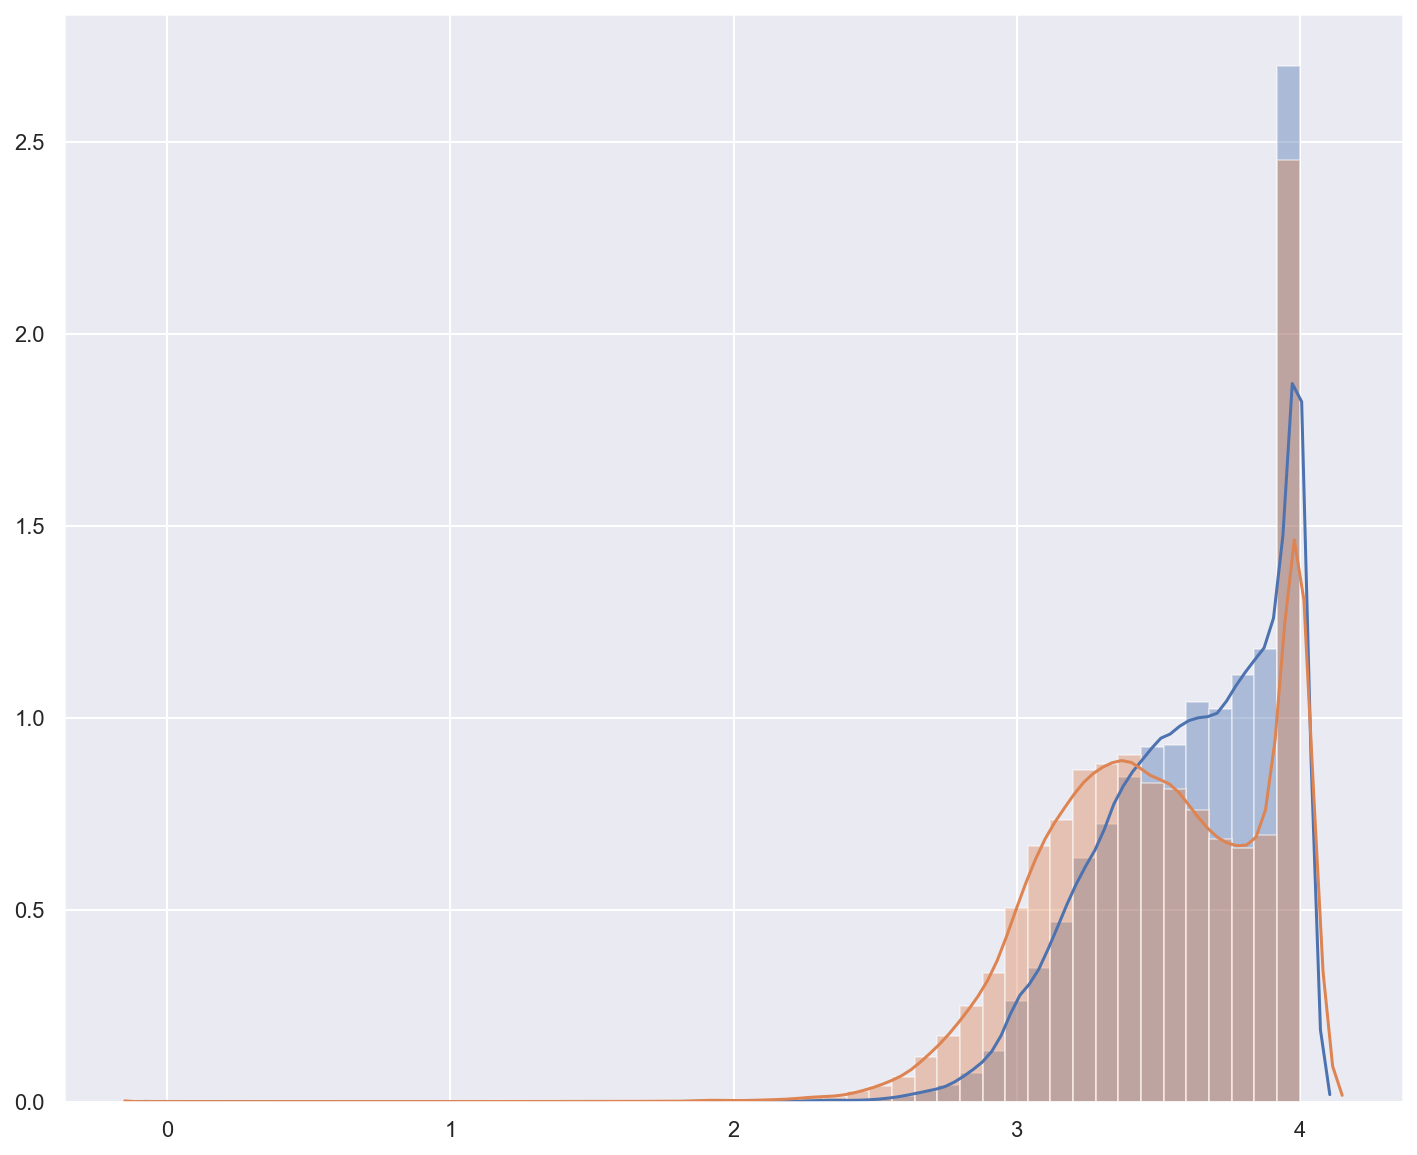

In [66]:
#SHERRY
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Green distribution

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [75]:
#We observe a difference between the two means. However, is this significant? 
control.mean()
experimental.mean()
x1_x2 = experimental.mean() - control.mean()

In [ ]:
#Let's try bootstrapping

In [74]:
import statistics 
import math 

s1 = statistics.stdev(control) 
s2 = statistics.stdev(experimental) 
n1 = len(control)
n2 = len(experimental)

s1_squared = s1**2
s2_squared = s2**2

standard_error_difference_two_means = math.sqrt((s1_squared/n1) + (s2_squared/n2))

In [77]:
z_score = (x1_x2 - 0)/standard_error_difference_two_means

In [78]:
z_score > 1.64

False

In [82]:
#Confirming our result 
Ttest_indResult = stats.ttest_ind(control, experimental, equal_var=False)

In [86]:
real_t_score=Ttest_indResult.statistic
real_t_score

51.47379902922791

In [85]:
real_pvalue=1-Ttest_indResult.pvalue/2
real_pvalue

1.0

In [96]:
from statsmodels.stats.weightstats import ztest

z, p_value = ztest(control, experimental)
z, p_value

(55.04763961022864, 0.0)

#####  Based on our findings, we cannot reject $H_0$  <br>


### Question 2: Do STEM mean grades get better as time goes on?
$H_0$: STEM mean grades in 2007 = STEM mean grades in 2017 <br>
$H_A$: STEM mean grades in 2007 < STEM mean grades in 2017 <br>
once again we will be using alpha of 0.05

In [102]:
#find statistics for a hypothesis test

STEM_o_seven_df = df_STEM.loc[df_STEM.year == '2007']
STEM_seventeen_df = df_STEM.loc[df_STEM.year == '2017']

In [103]:
df_STEM_o_seven = STEM_o_seven_df.dropna(axis=0, how='any')
df_STEM_o_seven['grade_ratio'].isna().sum()

df_STEM_seventeen = STEM_seventeen_df.dropna(axis=0, how='any')
df_STEM_seventeen['grade_ratio'].isna().sum()

0

In [104]:
STEM_o_seven_array = df_STEM_o_seven['grade_ratio'].values
STEM_seventeen_array = df_STEM_seventeen['grade_ratio'].values

control = STEM_o_seven_array
experimental = STEM_seventeen_array

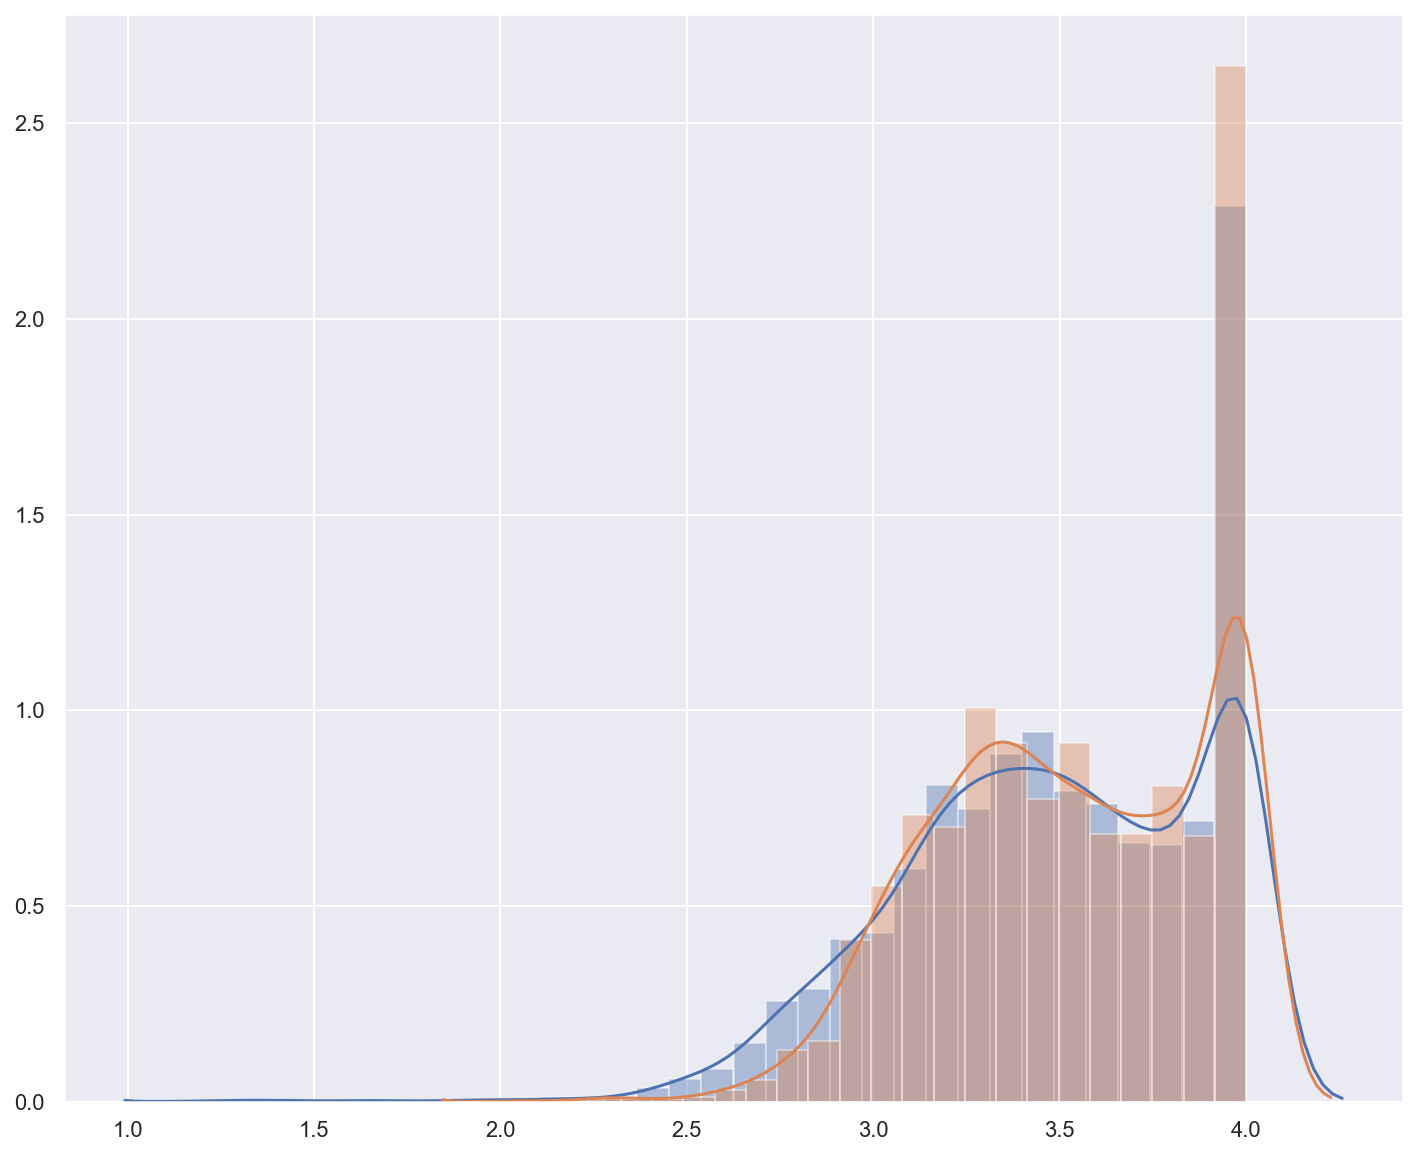

In [107]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Green distribution


In [108]:
#Is the difference significant? 
control.mean()
experimental.mean()
x1_x2 = experimental.mean() - control.mean()

In [109]:
s1 = statistics.stdev(control) 
s2 = statistics.stdev(experimental) 
n1 = len(control)
n2 = len(experimental)

s1_squared = s1**2
s2_squared = s2**2

standard_error_difference_two_means = math.sqrt((s1_squared/n1) + (s2_squared/n2))

In [110]:
z_score = (x1_x2 - 0)/standard_error_difference_two_means

In [111]:
z_score > 1.64

True

In [112]:
#Confirming our result 
Ttest_indResult = stats.ttest_ind(control, experimental, equal_var=False)

In [113]:
real_t_score=Ttest_indResult.statistic
real_t_score

-5.582976291171274

In [114]:
real_pvalue=1-Ttest_indResult.pvalue/2
real_pvalue

0.9999999876654891

In [115]:
z, p_value = ztest(control, experimental)
z, p_value

(-5.60326573133991, 2.103503577559272e-08)

#####  Based on our findings, we can reject $H_0$  <br>


### Question 3: do longer classes have higher mean grades than shorter classes?
$H_0$: longer class mean grade = shorter class mean grade <br>
$H_A$: longer class mean grade . shorter class mean grade <br>
we will be using alpha of 0.05

In [38]:
#make new column to measure the length of time in minutes
df_join['class_duration'] = (df_join.end_time - 
                             df_join.start_time)

In [39]:
#find a good short and long class time to use
#we settle with 50 minutes for short and
#120 minutes for long
df_join.class_duration.unique()

array([ 50,  75,   0,  85, 100,  80,  60, 120, 200, 150, 115, 160, 180,
       110,  90, 105,  55, 130, 155, 170, 145, 210, 165, 140,  70, 480,
       240, 510, 540,  95, 660, 720,  72, 300, 360, 520, 420, 270, 195,
       450,  45, 226, 125, 190, 175, 135, 245, 265, 250,  25, 225,   5,
       255, 189, 215,  65, 570, 435, 465, 205,  30, 390, 810, 330, 181,
        64,  40, 220, 185, 600,  88, 119, 555, 539, 630, 500,  35, 113,
       770, 325, 340, 690, 525, 645])

In [41]:
#find statistics for a hypothesis test
fifty_mean = df_join.loc[df_join.class_duration == 50].grade_ratio.mean()
fifty_std = df_join.loc[df_join.class_duration == 50].grade_ratio.std()
fifty_df = (df_join.loc[df_join.class_duration == 50].grade_ratio.count() -1)
one_twenty_mean = df_join.loc[df_join.class_duration == 120].grade_ratio.mean()
one_twenty_std = df_join.loc[df_join.class_duration == 120].grade_ratio.std()
one_twenty_df = (df_join.loc[df_join.class_duration == 120].grade_ratio.count() -1)

#perform hypothesis test
class_duration_z_score = ((one_twenty_mean -
                          fifty_mean)/fifty_std)
class_hypo_results = stats.norm.sf(class_duration_z_score)


In [42]:
class_hypo_results < alpha

False

In [ ]:
long_classes_T < alpha

#####  based on our findings, we cannot at this time reject $H_0$  <br>
results of the test was not conclusive because it always returns true

### Question 4: Do larger classes have lower mean grades than shorter classes?
$H_0$: larger class mean grade = smaller class mean grade <br>
$H_A$: larger class mean grade < smaller class mean grade <br>
We will be using alpha of 0.05

In [ ]:
#make new column to measure the size of classes
size_grades = df_join[['student_count', 'grade_ratio']]

#### find a good definition for large and small class sizes

In [ ]:
size_grades_final = size_grades.groupby(['student_count']).mean().reset_index()
print('The 25% quantile class size is ' + f"{size_grades_final['student_count'].quantile(.25)}")
print('The 50% quantile class size is ' + f"{size_grades_final['student_count'].quantile(.50)}")
print('The 75% quantile class size is ' + f"{size_grades_final['student_count'].quantile(.75)}")      

#### Based on this information, we are going to designate classes over 255 students a large a class size for this university.

In [ ]:
#find statistics for a hypothesis test
classes_large_mean = size_grades_final.loc[size_grades_final['student_count'] >= 255].mean()[1]
classes_large_std = size_grades_final.loc[size_grades_final['student_count'] >= 255].std()[1]
classes_large_df = (size_grades_final.loc[size_grades_final['student_count'] >= 255].count() -1)[1]
classes_small_mean = size_grades_final.loc[size_grades_final['student_count'] < 255].mean()[1]
classes_small_std = size_grades_final.loc[size_grades_final['student_count'] < 255].std()[1]
classes_small_df = (size_grades_final.loc[size_grades_final['student_count'] < 255].count() - 1)[1]

In [ ]:
large_vs_short_zscore = (classes_large_mean - classes_small_mean)/classes_small_std
large_vs_short_results = stats.norm.sf(large_vs_short_zscore)

In [ ]:
large_vs_short_results < alpha

In [ ]:
large_vs_small_t = two_t_test(classes_large_mean,
                              classes_small_mean,
                              classes_large_std,
                              classes_small_std,
                              classes_large_df,
                              classes_small_df)
large_vs_small_t < alpha

#####  based on our findings, we cannot at this time reject $H_0$  <br>


### Bootstrapping 